<a href="https://colab.research.google.com/github/nazianafis/Brain-MRI-Classification/blob/main/StackOverflow_Survey_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing Stack Overflow Survey 2020 Data**
*--check out the related Medium blog [here](https://nazianafis.medium.com/best-country-to-work-in-2020-15a790b00904)--*

---


In this project, we will be analyzing the 'Stack Overflow Annual Developer Survey 2020' data. The main survey results are in *survey_results_public.csv*, and you can download it [here](https://insights.stackoverflow.com/survey).

There are three main questions we will be focusing on in this analysis.

### Questions

1. Which country provides the highest job satisfaction for developers?
2. Is there a difference in job satisfaction between developers who had an IT related undergraduate major and those who didn't?
3. Do developers from non IT backgrounds think differently about the importance of having a formal education, such as a university degree in Computer Science, for their career?


---



### **Step 1: Data Acquisition & Preparation**

In [ ]:
!git clone https://github.com/nazianafis/StackOverflow-Data-Analysis.git

fatal: destination path 'StackOverflow-Data-Analysis' already exists and is not an empty directory.


In [ ]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/content/StackOverflow-Data-Analysis/survey_results_public.csv')
data.head

<bound method NDFrame.head of        Respondent  ...      YearsCodePro
0               1  ...                27
1               2  ...                 4
2               3  ...               NaN
3               4  ...                 4
4               5  ...                 8
...           ...  ...               ...
64456       64858  ...  Less than 1 year
64457       64867  ...               NaN
64458       64898  ...               NaN
64459       64925  ...               NaN
64460       65112  ...               NaN

[64461 rows x 61 columns]>

The dataset contains 64461 rows and 61 columns in total.

In [ ]:
# Filter data so that it only contains respondents who identify as 'developer'
developer_data = data[data['MainBranch'] == 'I am a developer by profession']

# Fill the NA values in 'JobSat' column with the mode
developer_data['JobSat'] = developer_data['JobSat'].fillna(developer_data['JobSat'].mode()[0])

# Fill the NA values in 'NEWEdImpt' column with the mode
developer_data['NEWEdImpt'] = developer_data['NEWEdImpt'].fillna(developer_data['NEWEdImpt'].mode()[0])


# Fill the NA values in 'ConvertedComp' column with the mean of each country
salary_per_country = developer_data.groupby('Country')['ConvertedComp'].mean()
developer_data['ConvertedComp'] = developer_data.fillna(lambda x: salary_per_country[x['Country']] if pd.isnull(x['ConvertedComp']) else x['ConvertedComp'], axis=1)
developer_data = developer_data.dropna(subset=['ConvertedComp'])

# Set 'JobSat' and 'NEWEdImpt' columns into categorical datatype so that they will be sorted with the right order (ordinal data)
developer_data['JobSat'] = pd.Categorical(developer_data['JobSat'], categories=['Very dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied','Slightly satisfied','Very satisfied'], ordered=True)

developer_data['NEWEdImpt'] = pd.Categorical(developer_data['NEWEdImpt'], categories=['Not at all important/not necessary','Somewhat important','Fairly important','Very important','Critically important'], ordered=True)

developer_data.head

<bound method NDFrame.head of        Respondent                      MainBranch  ... YearsCode      YearsCodePro
0               1  I am a developer by profession  ...        36                27
1               2  I am a developer by profession  ...         7                 4
3               4  I am a developer by profession  ...         7                 4
5               6  I am a developer by profession  ...         6                 4
6               7  I am a developer by profession  ...         6                 4
...           ...                             ...  ...       ...               ...
64154       65631  I am a developer by profession  ...         5  Less than 1 year
64155       65632  I am a developer by profession  ...       NaN               NaN
64157       65634  I am a developer by profession  ...       NaN               NaN
64158       65635  I am a developer by profession  ...         6  Less than 1 year
64159       65636  I am a developer by profession  ...   

So far, we have done the following-

* We filtered the data so it only contains respondents who identify as 'developer'.
* Because 'JobSat' and 'NEWEdImpt' columns contain categorical data, we filled all NA values with the respective modes.
* Because the differences in salary depend heavily on which country the developers live in, we filled all NA values in 'ConvertedComp' with the respective average salary of the developer's country. There were still some NA values present, since there were some countries whose average ConvertedComp == NaN (all of the respondents from that country didn't fill the salary form), so we just dropped those records.
* We set the 'JobSat' and 'NEWEdImpt' columns to categorical datatype.


---




### **Step 2: Data Exploration**

**1. Country with the Highest Job Satisfaction Rates for Developers**

In [ ]:
# Filter the data so that it only contains the survey result from top 20 countries based on the number of total respondents
top_20_countries = list(developer_data['Country'].value_counts().head(20).index)
filtered_developer_data = developer_data[developer_data['Country'].isin(top_20_countries)]

# Aggregate the data so we can visualize it later
aggregated_data = filtered_developer_data.groupby(['Country','JobSat'], as_index=False)['Respondent'].count()

# Add column percentage
total_respondents_per_country = filtered_developer_data['Country'].value_counts()

aggregated_data['Respondent Percentage'] = aggregated_data.apply(lambda x: x['Respondent'] / total_respondents_per_country[x['Country']], axis=1).round(3)

# Pivot the data
aggregated_data = aggregated_data[['Country', 'JobSat', 'Respondent Percentage']]
pivoted_data = pd.pivot_table(aggregated_data, values='Respondent Percentage', index='Country', columns='JobSat').sort_values('Very satisfied', ascending=False)

Because the survey contains data of respondents from more than 180 countries, we narrowed it down to the top 20 countries based on each country's total number of respondents. This was done because we want to analyze data from as many respondents as possible for each country, and each country in the top 20 has atleast 400 respondents (which is a good enough number for our analysis).

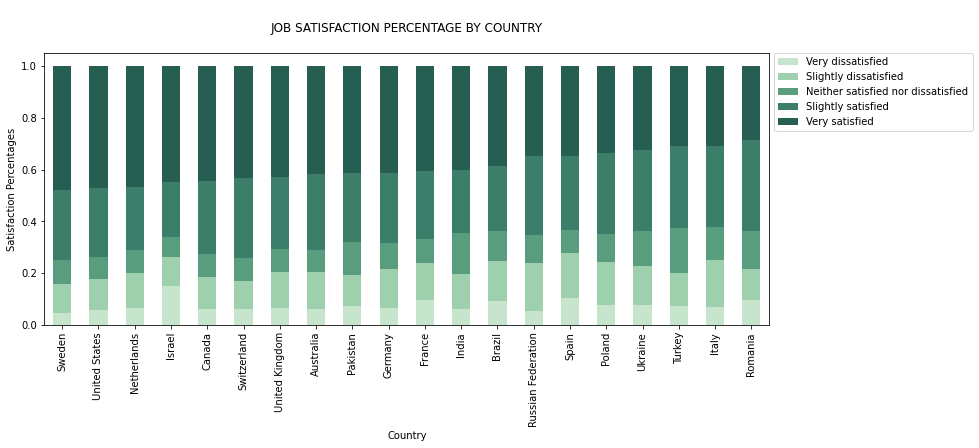

In [ ]:
# Visualize the data
pivoted_data.plot(kind='bar',stacked=True,colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.3")),figsize=(13,5))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.ylabel('Satisfaction Percentages')
plt.title('\nJOB SATISFACTION PERCENTAGE BY COUNTRY\n')
plt.show()

The data shows that Sweden is the best country in terms of job satisfaction for developers, with almost 50% of the developers feeling very satisfied. United States ranks second in the world and Netherlands is third.

**2. Undergraduate Major and Job Satisfaction**


In [ ]:
# Create a new column to flag each respondent if their major is related or not
def check_major(value):
    '''
    input: the value of each row in the selected column
    output: the mapped value based on the criteria in this function
    '''

    if value == 'Computer science, computer engineering, or software engineering' or value == 'Information systems, information technology, or system administration' or value == 'Web development or web design':
        return 'IT Related'
    return 'Non IT Related'

developer_data['Major'] = developer_data['UndergradMajor'].apply(check_major)

developer_data['Major'].value_counts(normalize=True)

IT Related        0.652067
Non IT Related    0.347933
Name: Major, dtype: float64

We cateogrized the 'UndergradMajor' column into two- 'IT Related' and 'Non IT Related'. We saw that 65% of developers have an IT related undergraduate major.

In [ ]:
# Aggregate the data so that we know how many respondents are there in each type of major ('IT related' and 'non IT related')
aggregated_data = developer_data.groupby(['Major','JobSat'], as_index=False)['Respondent'].count()

# Add column percentage
total_respondents_per_major = developer_data['Major'].value_counts()

aggregated_data['Respondent Percentage'] = aggregated_data.apply(lambda x: x['Respondent'] / total_respondents_per_major[x['Major']], axis=1).round(4)

# Pivot the data
aggregated_data = aggregated_data[['Major', 'JobSat', 'Respondent Percentage']]
pivoted_data = pd.pivot_table(aggregated_data, values='Respondent Percentage', index='Major', columns='JobSat')

Then we calculated the percentages of each value in 'JobSat' to measure job satisfaction for each type of major.

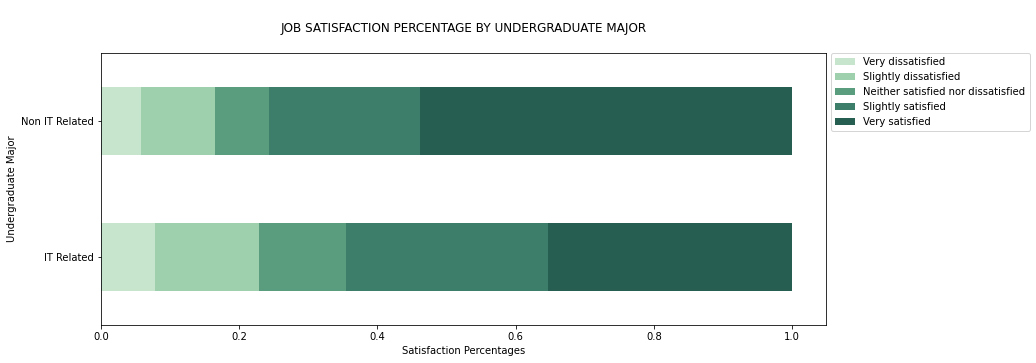

In [ ]:
# Visualize the data
pivoted_data.plot(kind='barh',stacked=True,colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.3")),figsize=(13,5))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.xlabel('Satisfaction Percentages')
plt.ylabel('Undergraduate Major')
plt.title('\nJOB SATISFACTION PERCENTAGE BY UNDERGRADUATE MAJOR\n')
plt.show()

In [ ]:
pivoted_data

JobSat,Very dissatisfied,Slightly dissatisfied,Neither satisfied nor dissatisfied,Slightly satisfied,Very satisfied
Major,,,,,
IT Related,0.0775,0.1511,0.1262,0.2915,0.3537
Non IT Related,0.0585,0.1057,0.0788,0.2192,0.5378


From the above visualization and table, we found that developers whose undergraduate major is 'Non IT related' have better job satisfaction as compared those who have an 'IT related' background, with 53% and 35% respondents feeling very satisfied respectively.

**3. Importance of Formal Education**

In [ ]:
# Aggregate the data to know the number of respondents in each type of major ('IT related' / 'Non IT related')
aggregated_data = developer_data.groupby(['Major','NEWEdImpt'], as_index=False)['Respondent'].count()

# Add column percentage
total_respondents_per_major = developer_data['Major'].value_counts()

aggregated_data['Respondent Percentage'] = aggregated_data.apply(lambda x: x['Respondent'] / total_respondents_per_major[x['Major']], axis=1).round(4)

# Pivot the data
aggregated_data = aggregated_data[['Major', 'NEWEdImpt', 'Respondent Percentage']]
pivoted_data = pd.pivot_table(aggregated_data, values='Respondent Percentage', index='Major', columns='NEWEdImpt')

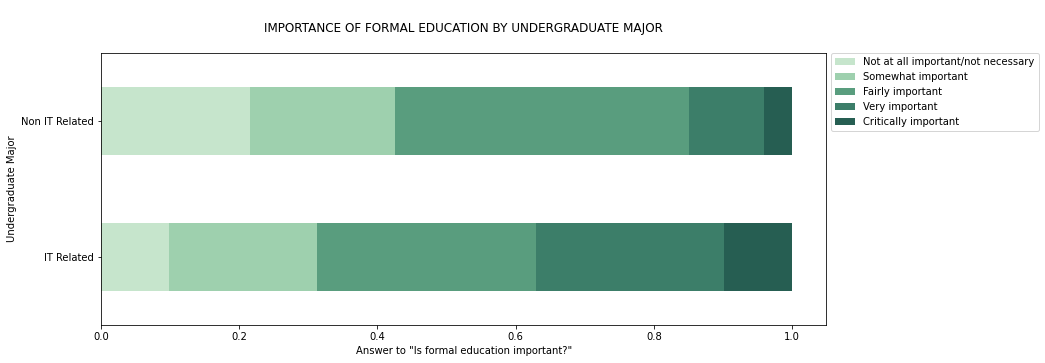

In [ ]:
# Visualize the data
pivoted_data.plot(kind='barh',stacked=True,colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.3")),figsize=(13,5))
plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.xlabel('Answer to "Is formal education important?"')
plt.ylabel('Undergraduate Major')
plt.title('\nIMPORTANCE OF FORMAL EDUCATION BY UNDERGRADUATE MAJOR\n')
plt.show()


From the above visualization and table, we find out that developers with an IT related background agree more with the importance of having a formal education, such as a university degree in Computer Science, for their career.



---


### **Conclusion**

In this project, we analyzed developer data from 'Stack Overflow Annual Developer Survey 2020'. This is a quick summary of what we found-
1. We measured job satisfaction levels for each country and found that Sweden topped the charts. United States stood second and Netherlands third.
2. Then, we looked at undergraduate majors and found that developers who majored in 'Non IT related' fields have better job satisfaction.
3. At last, we found that developers from 'Non IT related' fields were also the ones who believed that having a formal education, such as a degree in Computer Science, was not as important for their career. This is also backed up by the fact that despite not having a background in IT, these respondents are not only working as developers but also have higher job satisfaction in their work.


---


I encourage you to dig deeper into the dataset and draw more useful correlations and interesting analyses from it.